# Descrição do Projeto

A Film Junky Union, uma nova comunidade para entusiastas de filmes clássicos, está desenvolvendo um sistema para filtrar e categorizar resenhas de filmes. O objetivo é treinar um modelo para detectar automaticamente resenhas negativas. Você usará um conjunto de dados de resenhas de filmes do IMDB com rotulagem de polaridade para criar um modelo para classificar resenhas como positivas e negativas. Ele precisará ter um valor F1 de pelo menos 0,85.

# Dicionario dos dados

   - tcost  -   Total cost (não presente nos dados fornecidos)
   
   - title_type  - Tipo do título
   
   - primary_title  -  Título principal
   
   - original_title  - Título original
   
   - start_year -  Ano de início
   
   - end_year' -  Ano de término
   
   - runtime_minutes  -  Duração em minutos
   
   - is_adult  -  Indicação se é conteúdo adulto
   
   - genres - Gêneros
   
   - average_rating  -  Avaliação média
   
   - votes  - Número de votos
   
   - review  -  Revisão
   
   - rating  - Classificação
   
   - sp  -  Não definido
   
   - pos  -  Posição
   
   - ds_part -  Não definido
   
   - idx  -   Índice
  



In [4]:
!pip install spacy -q
!pip install seaborn -q
!pip install nltk -q
!pip install torch -q
!pip install transformers -q


## Bibliotecas

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import spacy
import re
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore", message="Support for alternate kernels has been removed.")




In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('ggplot')
plt.style.use('seaborn')

###  isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration

In [6]:

tqdm.pandas()

## Carregar Dados

In [7]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


### Informação dos dados

In [8]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

### Verificando estatistica dos dados

In [9]:
df_reviews.describe().T

,count,mean,std,min,25%,50%,75%,max
start_year,47331.0,1989.631235,19.600364,1894.0,1982.0,1998.0,2004.0,2010.0
is_adult,47331.0,0.001732,0.041587,0.0,0.0,0.0,0.0,1.0
average_rating,47329.0,5.998278,1.494289,1.4,5.1,6.3,7.1,9.7
votes,47329.0,25562.917323,83670.039163,9.0,827.0,3197.0,13974.0,1739448.0
rating,47331.0,5.484608,3.473109,1.0,2.0,4.0,9.0,10.0
pos,47331.0,0.498954,0.500004,0.0,0.0,0.0,1.0,1.0
idx,47331.0,6279.697999,3605.702545,0.0,3162.0,6299.0,9412.0,12499.0


### Verificando dados ausentes

In [10]:
df_reviews[['tconst','title_type','primary_title','original_title','start_year','end_year','runtime_minutes',
           'is_adult','genres','average_rating','votes','review','rating','sp','pos','ds_part','idx',]].isna().sum()

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

Foi observado dados ausentes nas colunas average_rating e votes, quantidade de ausentes muito pequena não causa dano ao projeto, vou retirar as linhas correspondentes.

### Retirada das linhas nulas

In [11]:
df_reviews = df_reviews.dropna()

## AED

### Vamos verificar o número de filmes e resenhas ao longo dos anos.

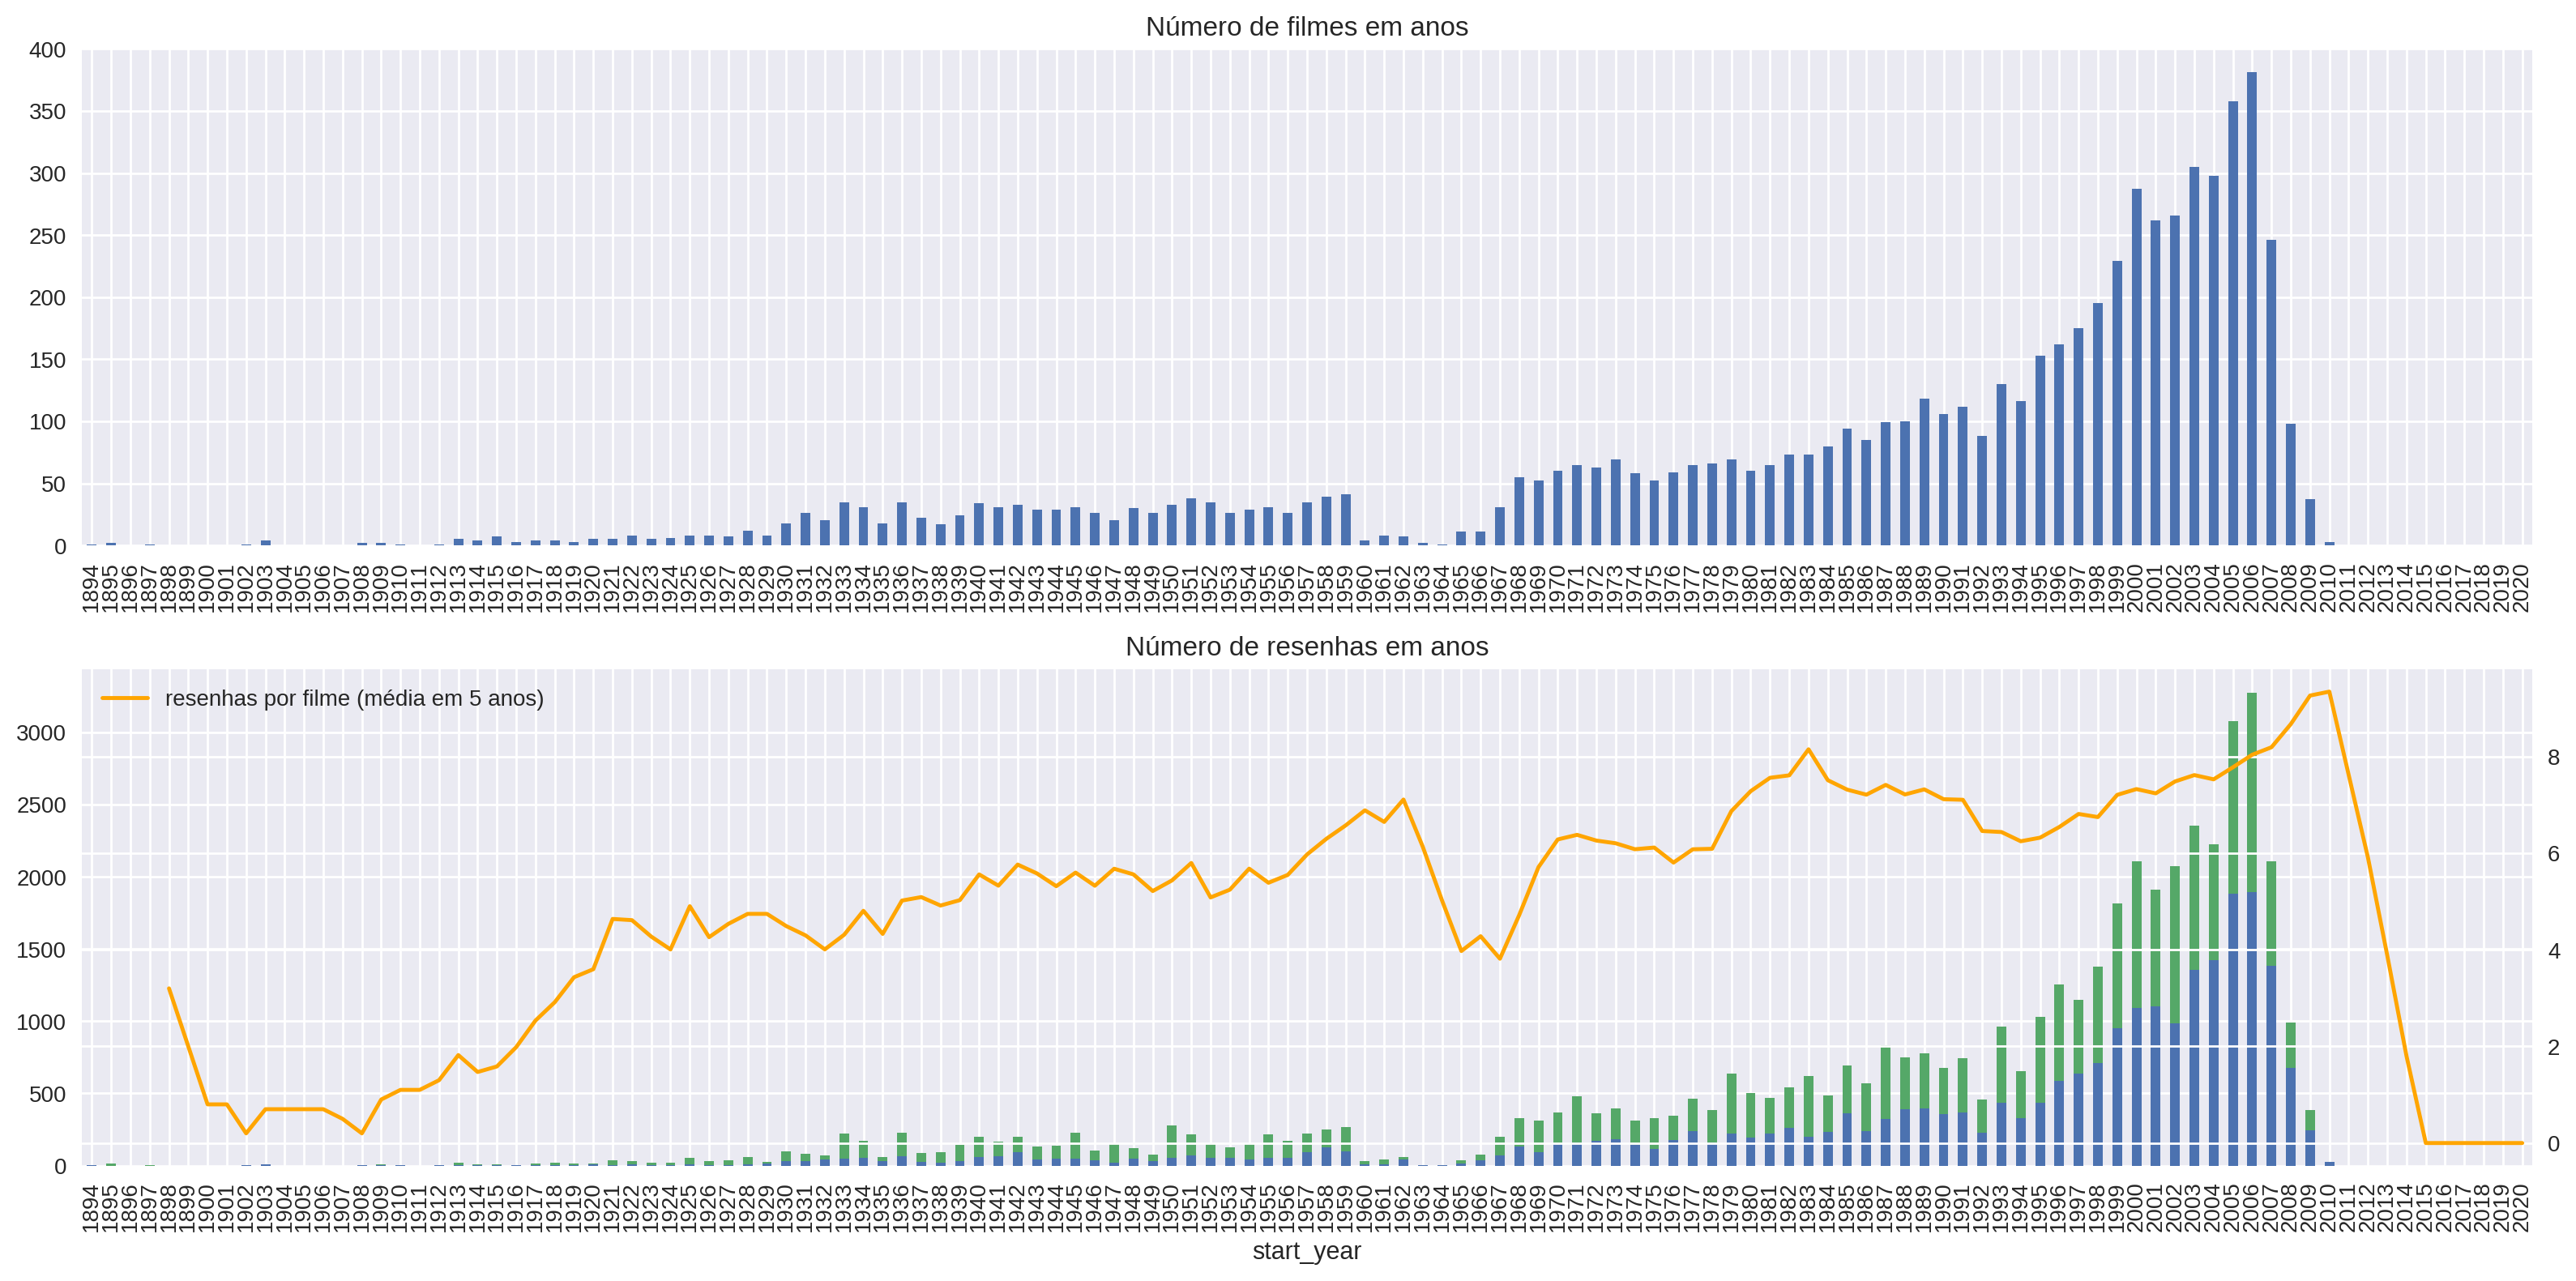

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

Vamos verificar a distribuição do número de resenhas por filme com a contagem exata e o EDK (Estimativa de densidade kernel - só para saber como pode diferir da contagem exata)

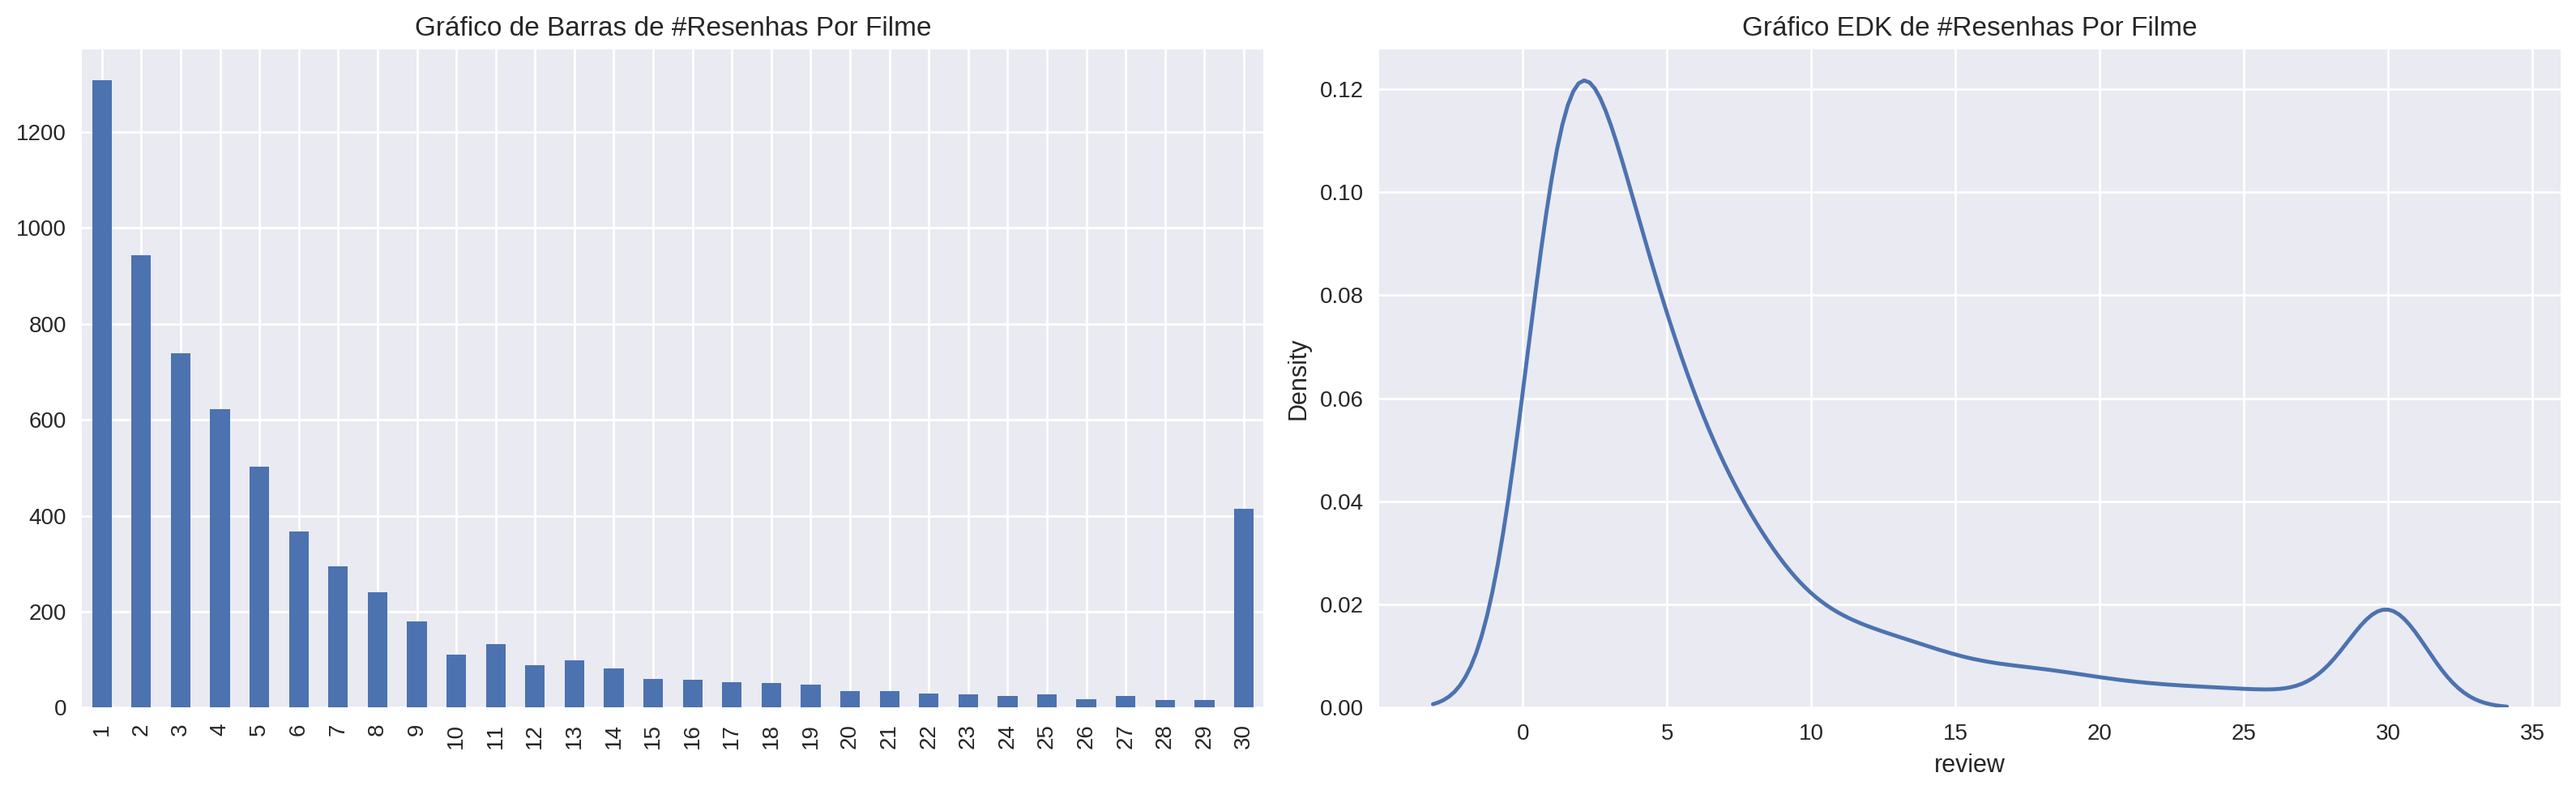

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

### Ocorrências para cada valor único na coluna 

In [14]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

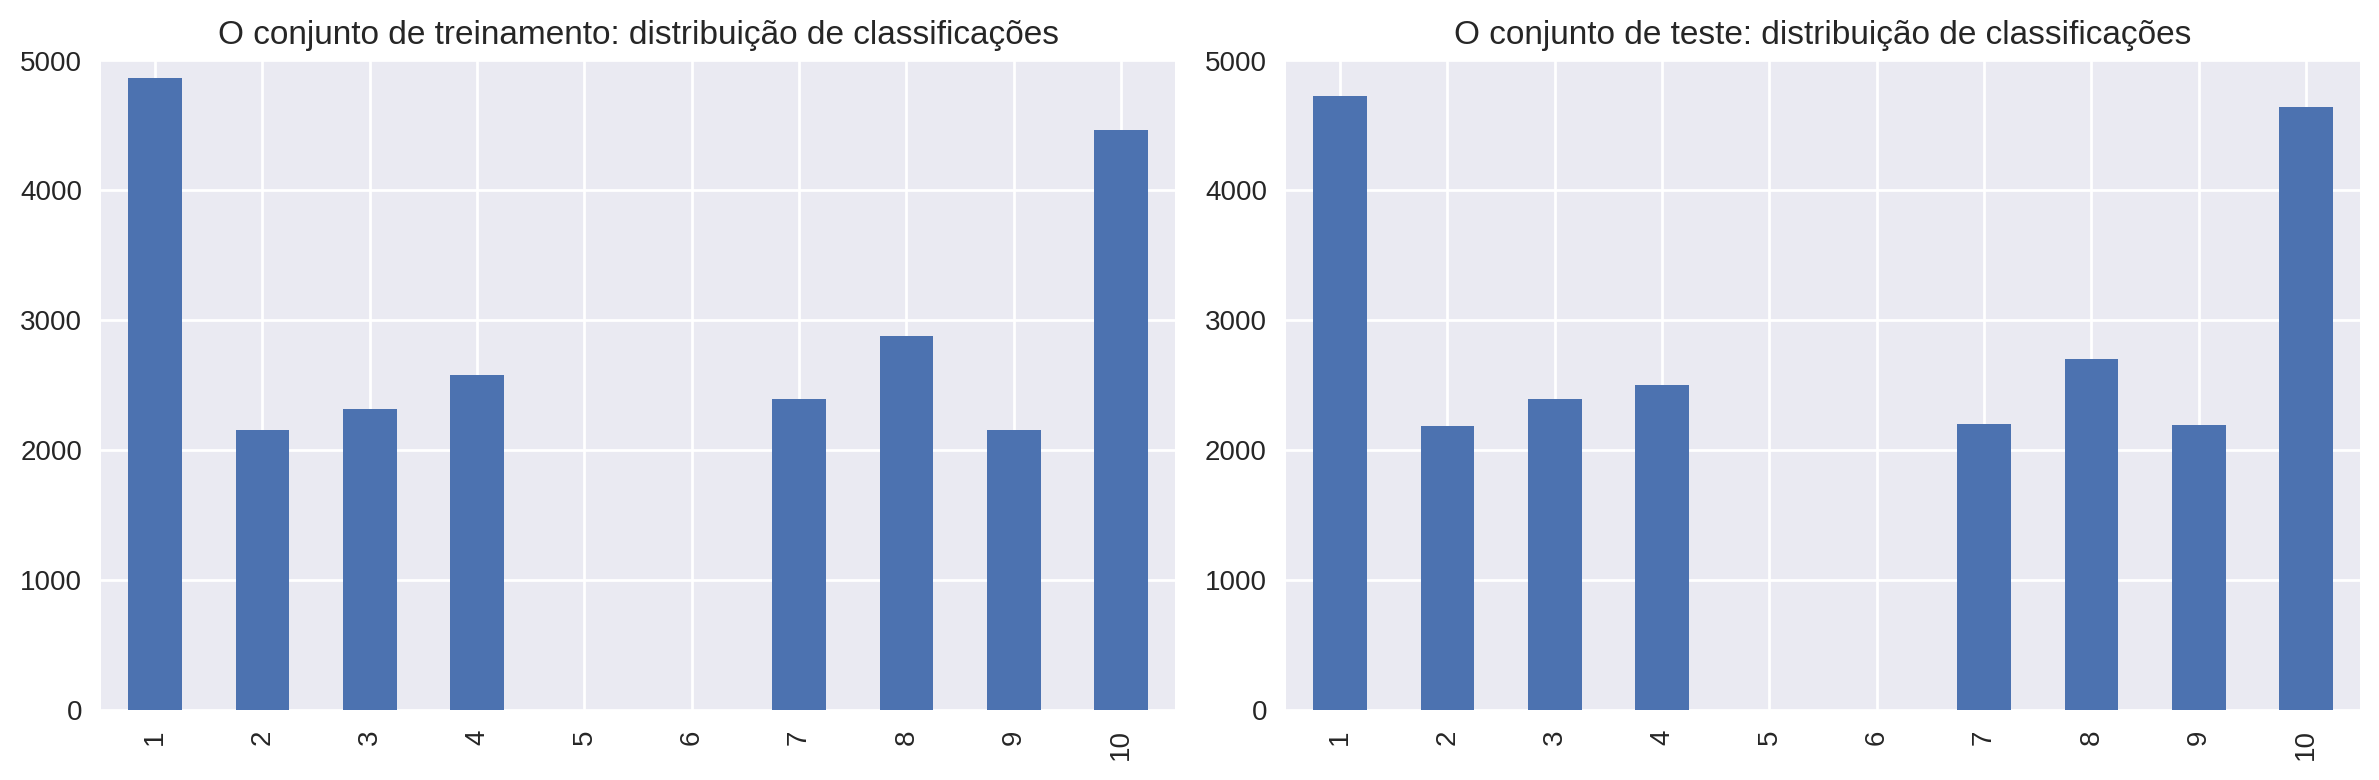

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

Distribuição de resenhas negativas e positivas ao longo dos anos para duas partes do conjunto de dados

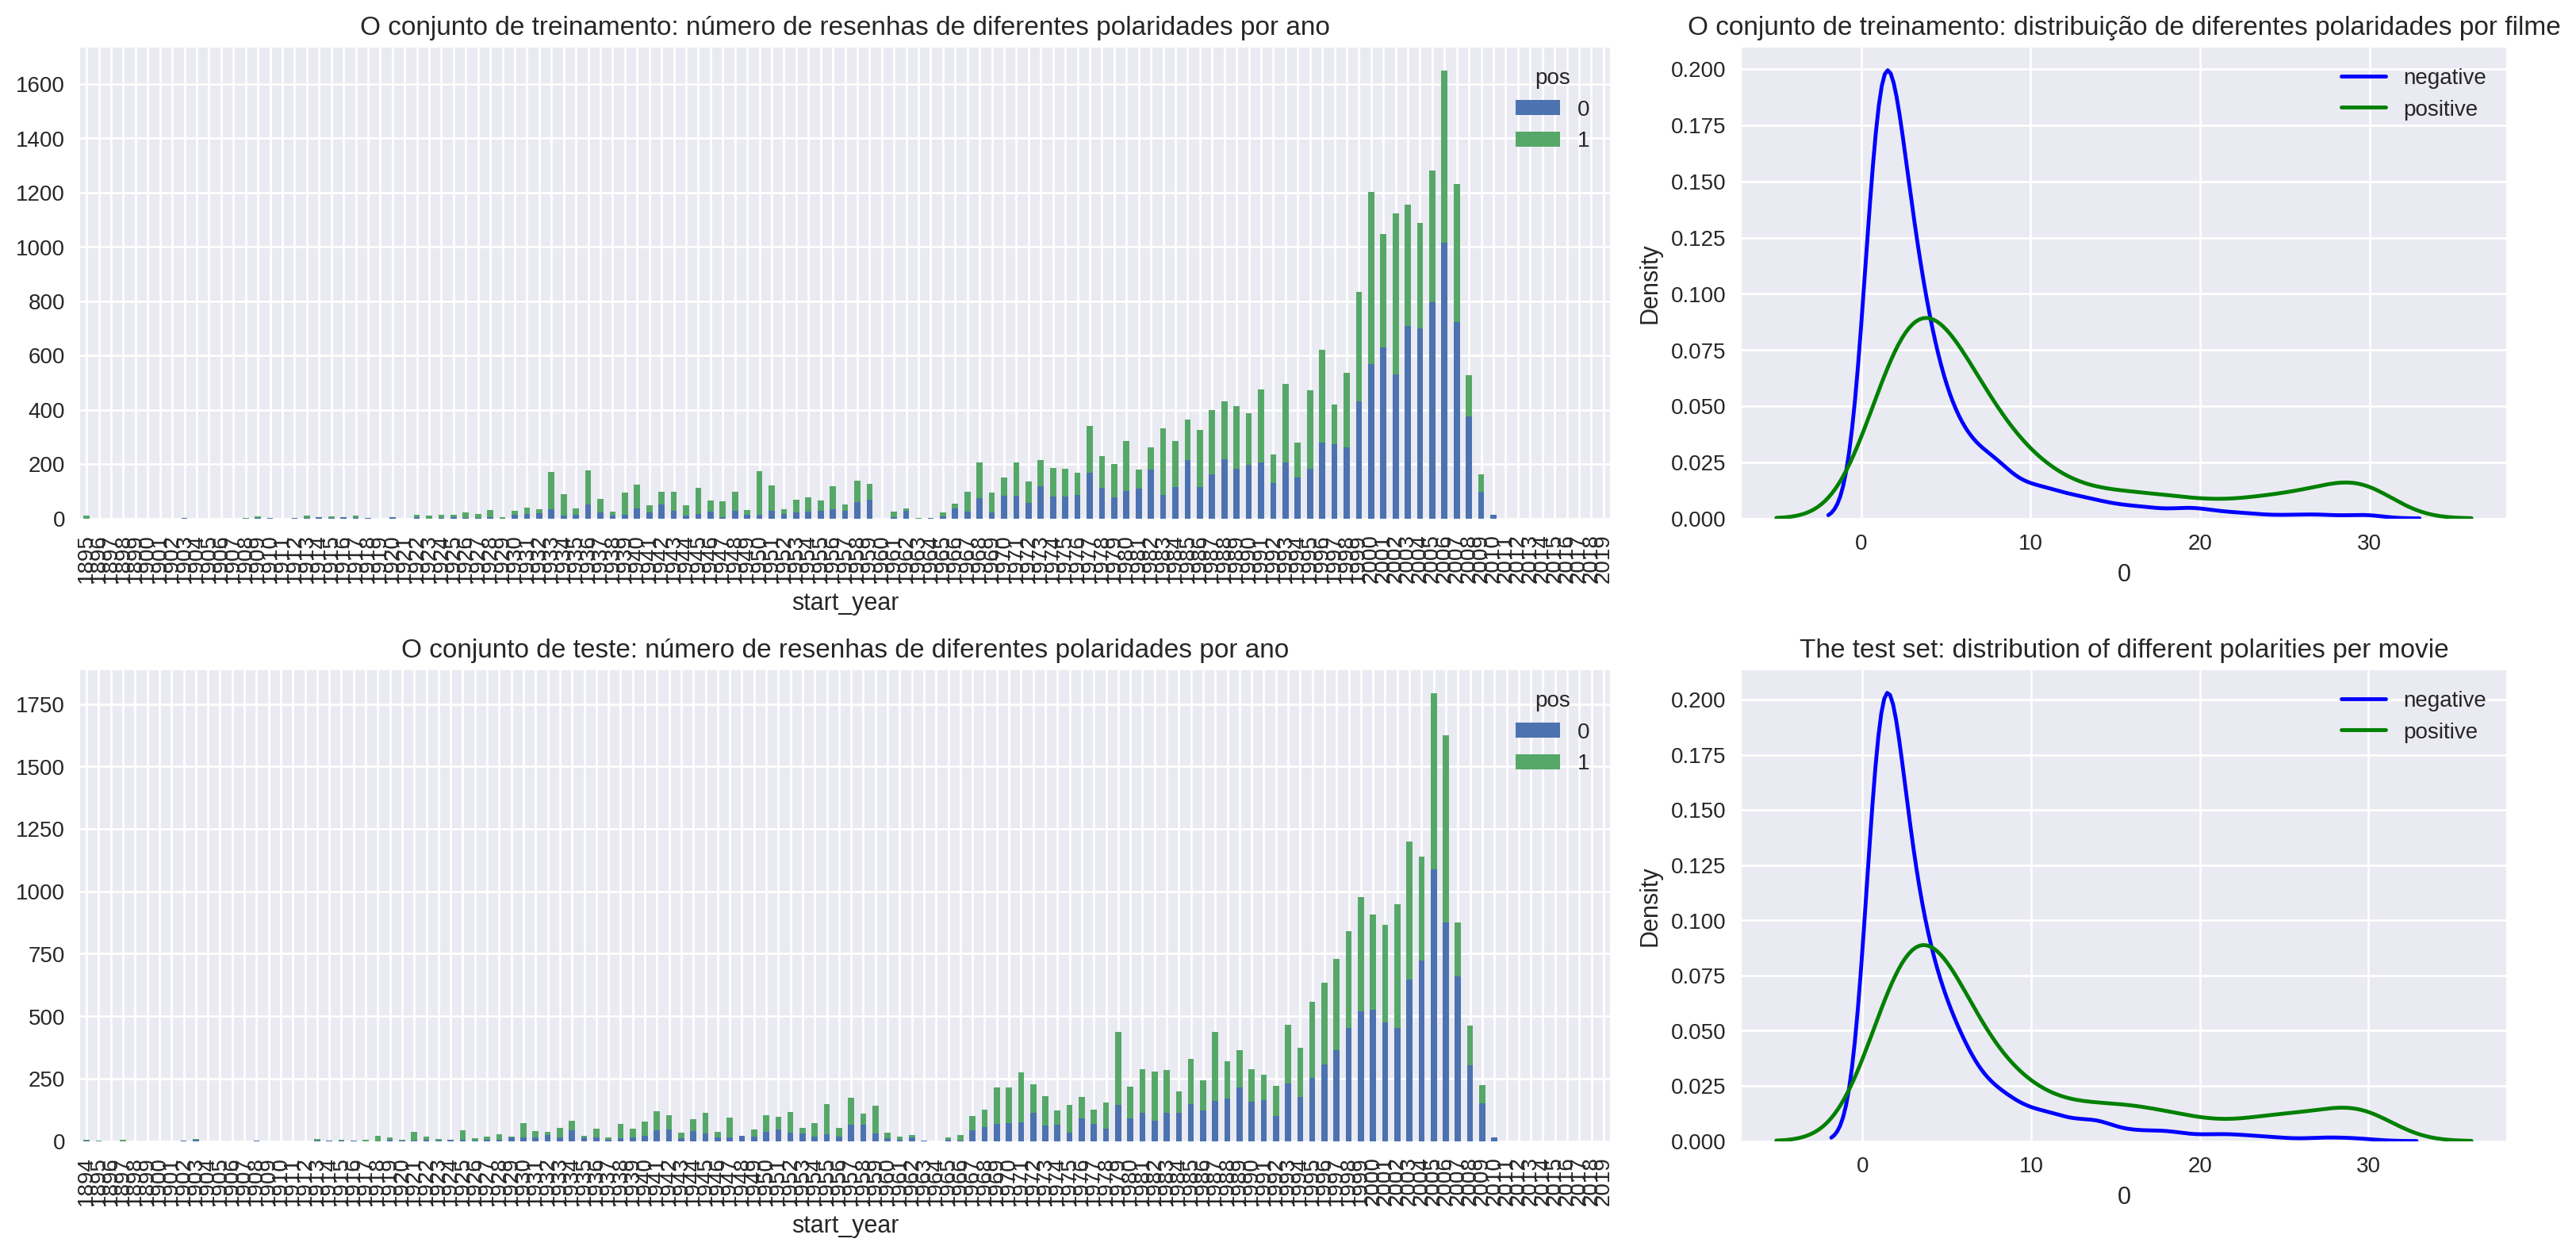

In [16]:


fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Procedimento de Avaliação

Compondo uma rotina de avaliação que pode ser utilizada para todos os modelos deste projeto

In [17]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalização

Assumimos que todos os modelos abaixo aceitam textos em letras minúsculas e sem dígitos, sinais de pontuação, etc.

In [18]:
def clear_text(text):

    clean_text = re.sub(r'[^a-zA-z\']', ' ', text).lower()
    clean_text = " ".join(clean_text.split())

    return clean_text

In [19]:
df_reviews['review_norm'] =  df_reviews['review'].apply(clear_text)
df_reviews['review_norm']

0        the pakage implies that warren beatty and gold...
1        how the hell did they get this made presenting...
2        there is no real story the film seems more lik...
3        um a serious film about troubled teens in sing...
4        i'm totally agree with garryjohal from singapo...
                               ...                        
47326    this is another of my favorite columbos it spo...
47327    talk about being boring i got this expecting a...
47328    i never thought i'd say this about a biopic bu...
47329    spirit and chaos is an artistic biopic of miya...
47330    i'll make this brief this was a joy to watch i...
Name: review_norm, Length: 47329, dtype: object

## Treinar / Testar Conjunto

Felizmente, todo o conjunto de dados já está dividido em partes de treinamento/teste. A opção correspondente é 'ds_part'.

In [20]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Trabalhando com modelos

### Modelo 0 - Constante

In [21]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [22]:
model_constante = DummyClassifier(strategy='constant', constant=1)

In [23]:
model_constante.fit(df_reviews_train, train_target)
y_pred = model_constante.predict(df_reviews_test)

In [24]:
accuracy = accuracy_score(test_target, y_pred)
print('Acurácia:', accuracy)

Acurácia: 0.4984489865295542


In [25]:
f1_score(test_target, y_pred)

0.6652865609846014

## Modelo 1 - NLTK, TF-IDF e Regressão Linear

TF-IDF

In [26]:
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords

In [27]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

tfidf_vectorizer_1 = TfidfVectorizer()
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Treinamento do modelo de regressão logística

In [28]:
model_1 = LogisticRegression()
model_1.fit(train_features_1, train_target)

LogisticRegression()

### Avaliação do modelo

In [29]:
y_pred_1 = model_1.predict(test_features_1)

In [30]:
f1_score(test_target, y_pred_1)

0.8813602768402614

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.95
ROC AUC    0.98  0.95


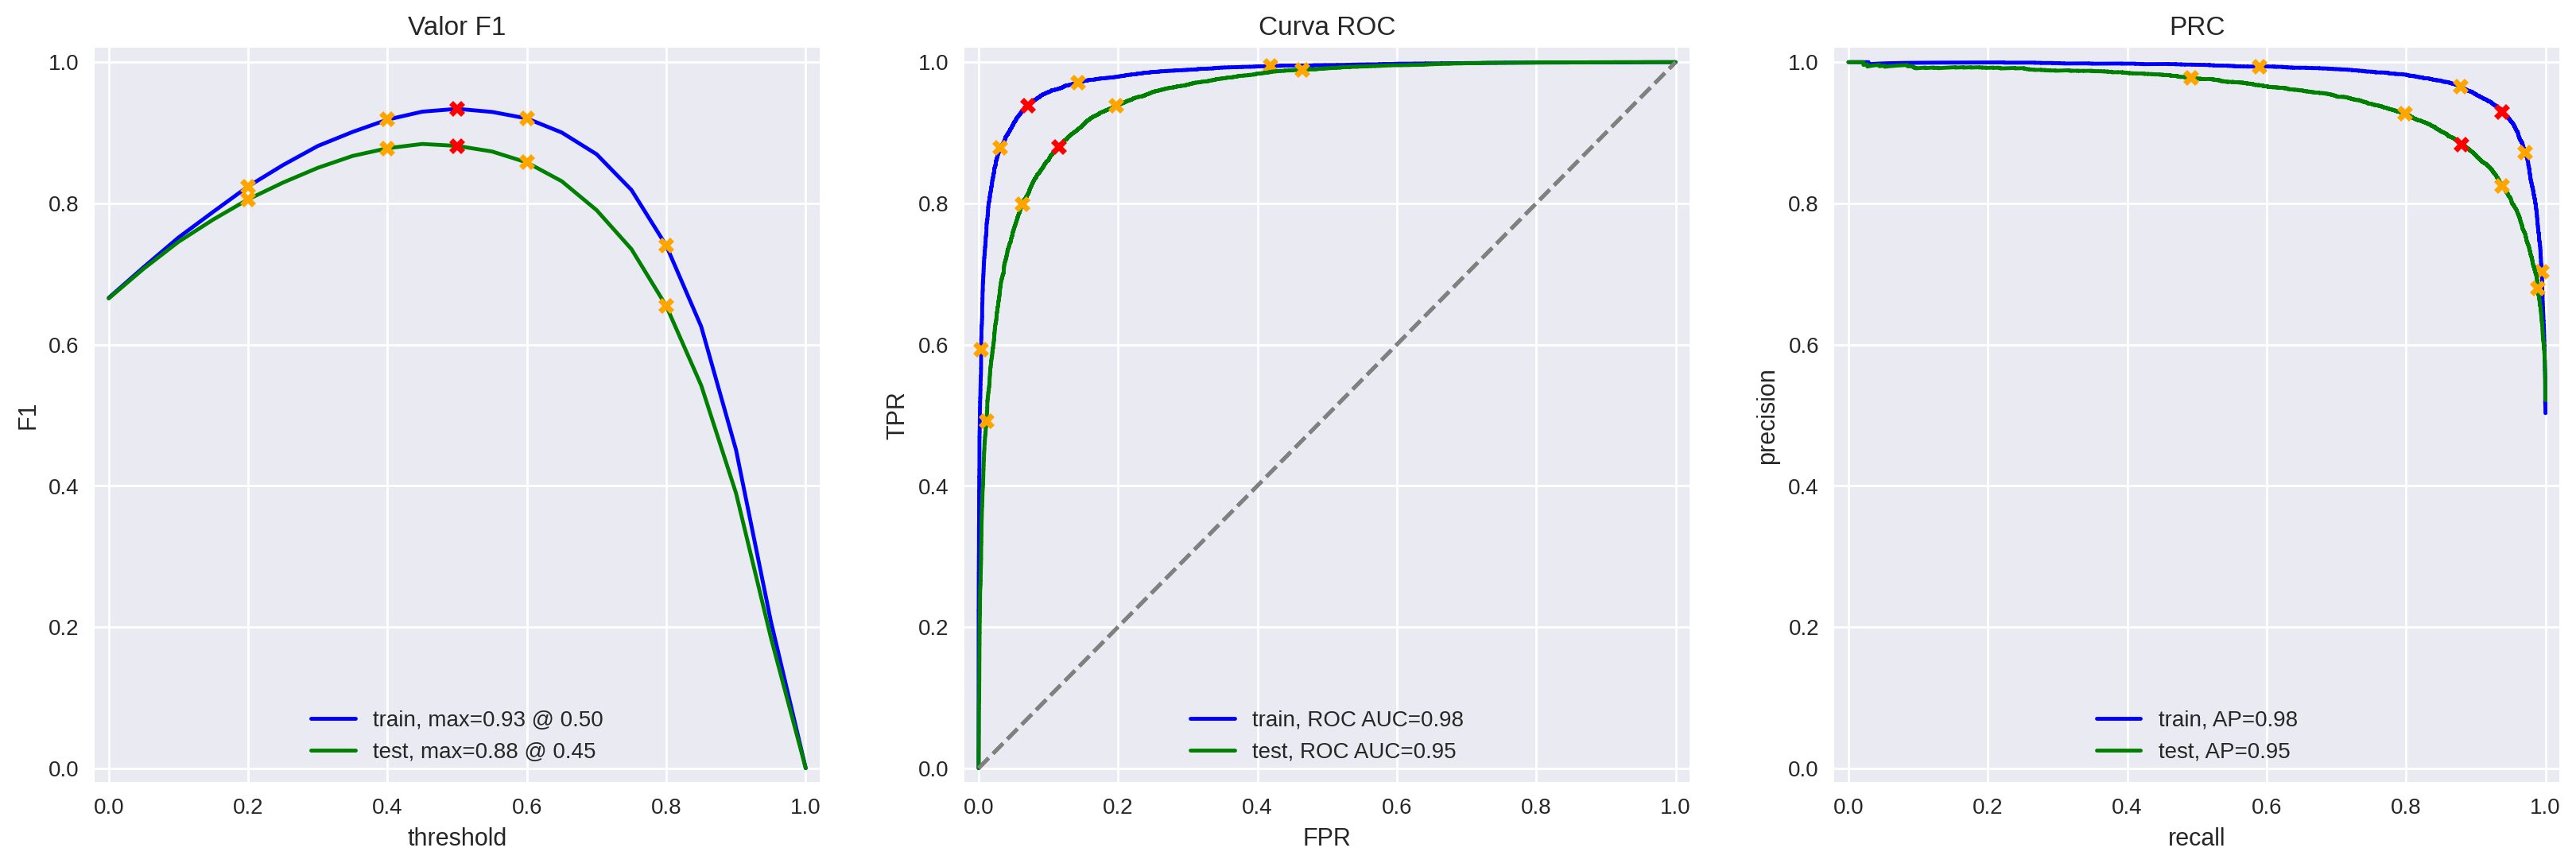

In [31]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

Observado o modelo de regressão logística con NLTK apresenta a métrica F1 acima do modelo constante e do limiar determinado no projeto.



## Modelo 2 - spaCy, TF-IDF e Regressão Linear

In [32]:

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [34]:
df_reviews_train['review_norm_processing'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_norm_processing'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

In [35]:
tfidf_vectorizer_2 = TfidfVectorizer()
train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm_processing'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm_processing'])

### Treinamento do modelo de regressão logística

In [36]:
model_2 = LogisticRegression()
model_2.fit(train_features_2, train_target)

LogisticRegression()

### Avaliação do modelo

In [37]:
y_pred_2 = model_2.predict(test_features_2)

In [38]:
f1_score(test_target, y_pred_2)

0.8752925158490406

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.94
ROC AUC    0.98  0.95


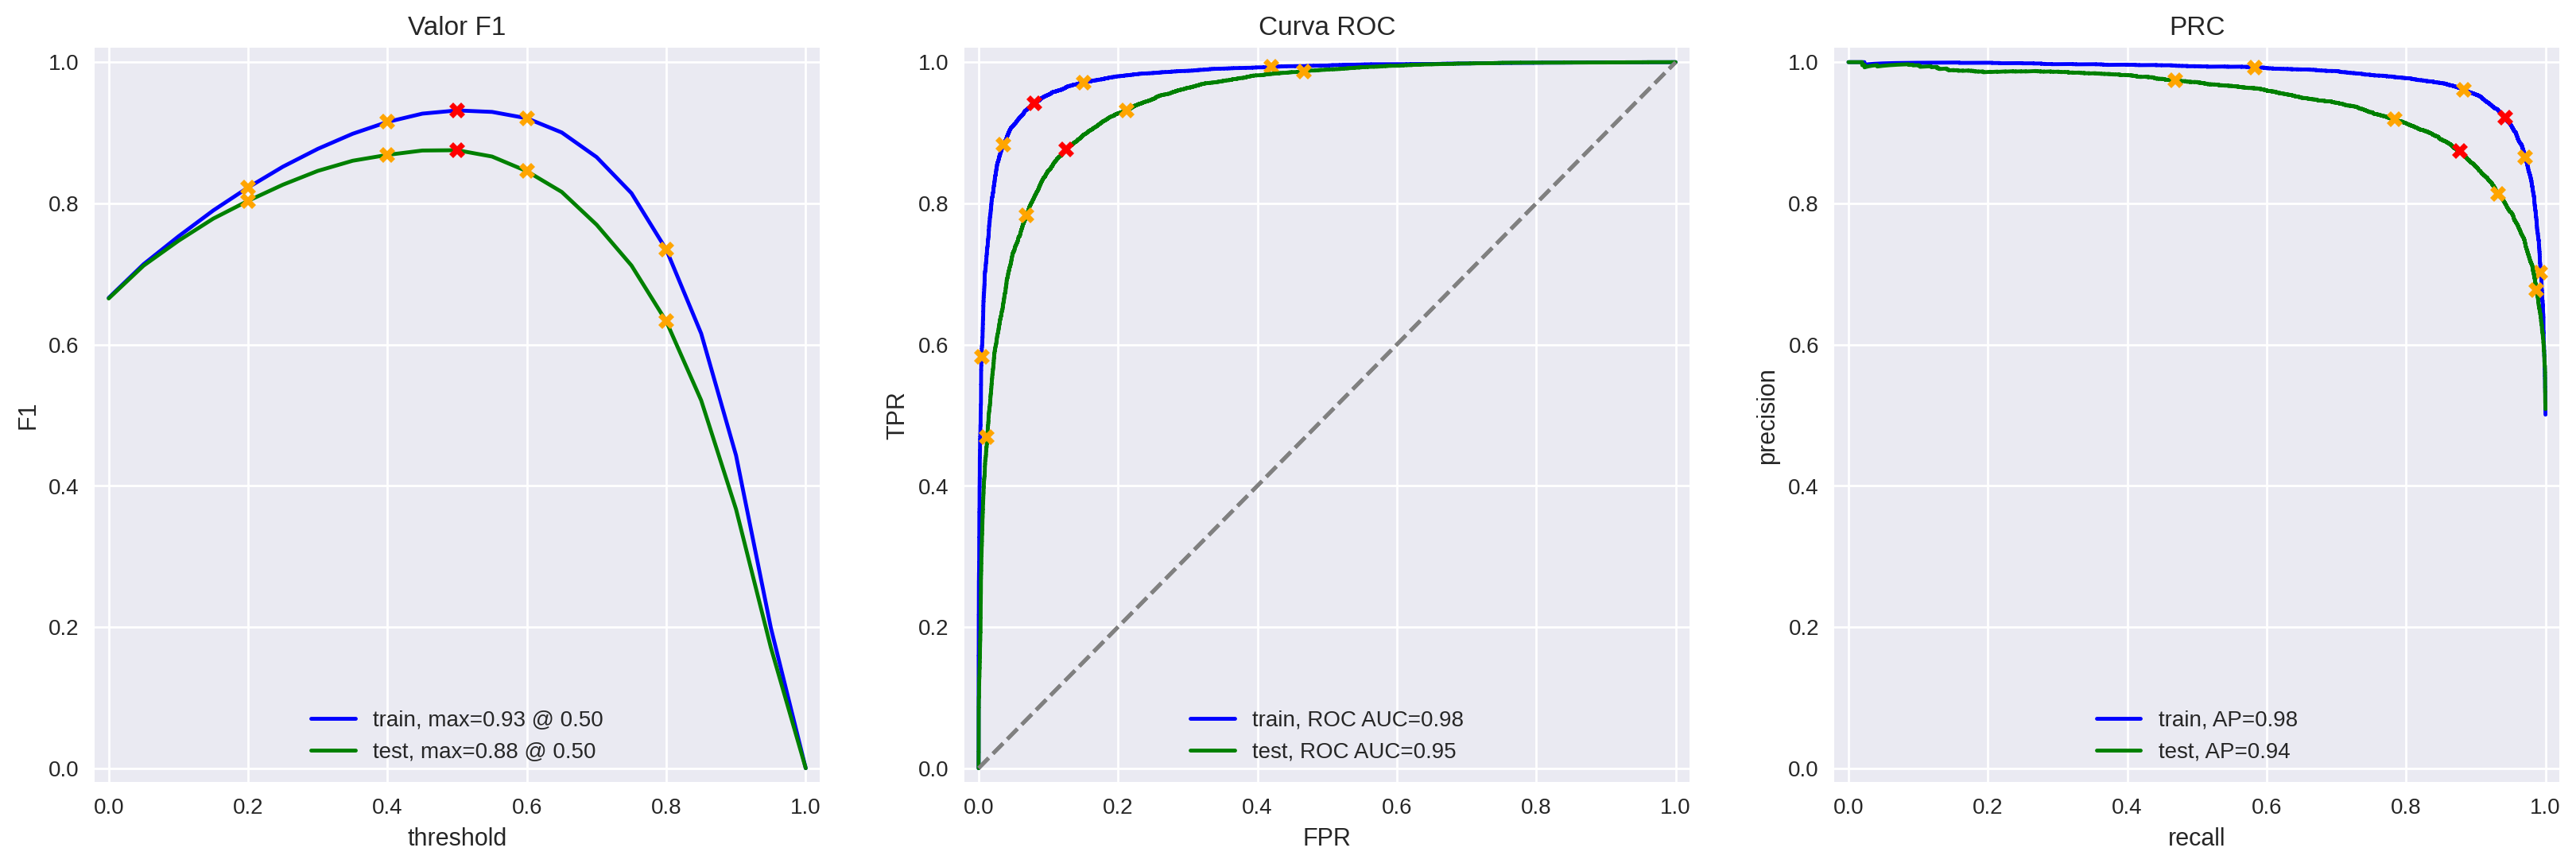

In [39]:
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

Foi observado o modelo de  regressão logística com spaCy apresenta a métrica F1 acima do modelo constante e do limiar determinado no projeto

## Modelo 3 - SpaCy, TF-IDF e LGBMClassifier

In [40]:
from lightgbm import LGBMClassifier

In [41]:
tfidf_vectorizer_3 = TfidfVectorizer()
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_norm_processing'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_norm_processing'])

### Criar o modelo LGBMClassifier

In [42]:
model_3 = LGBMClassifier()

### Treinar o modelo

In [43]:
model_3.fit(train_features_3, train_target)

LGBMClassifier()

### Fazer predições nos dados de teste

In [44]:
y_pred_3 = model_3.predict(test_features_3)

In [45]:
f1_score(test_target, y_pred_3)

0.854079608290068

          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.97  0.93
ROC AUC    0.97  0.93


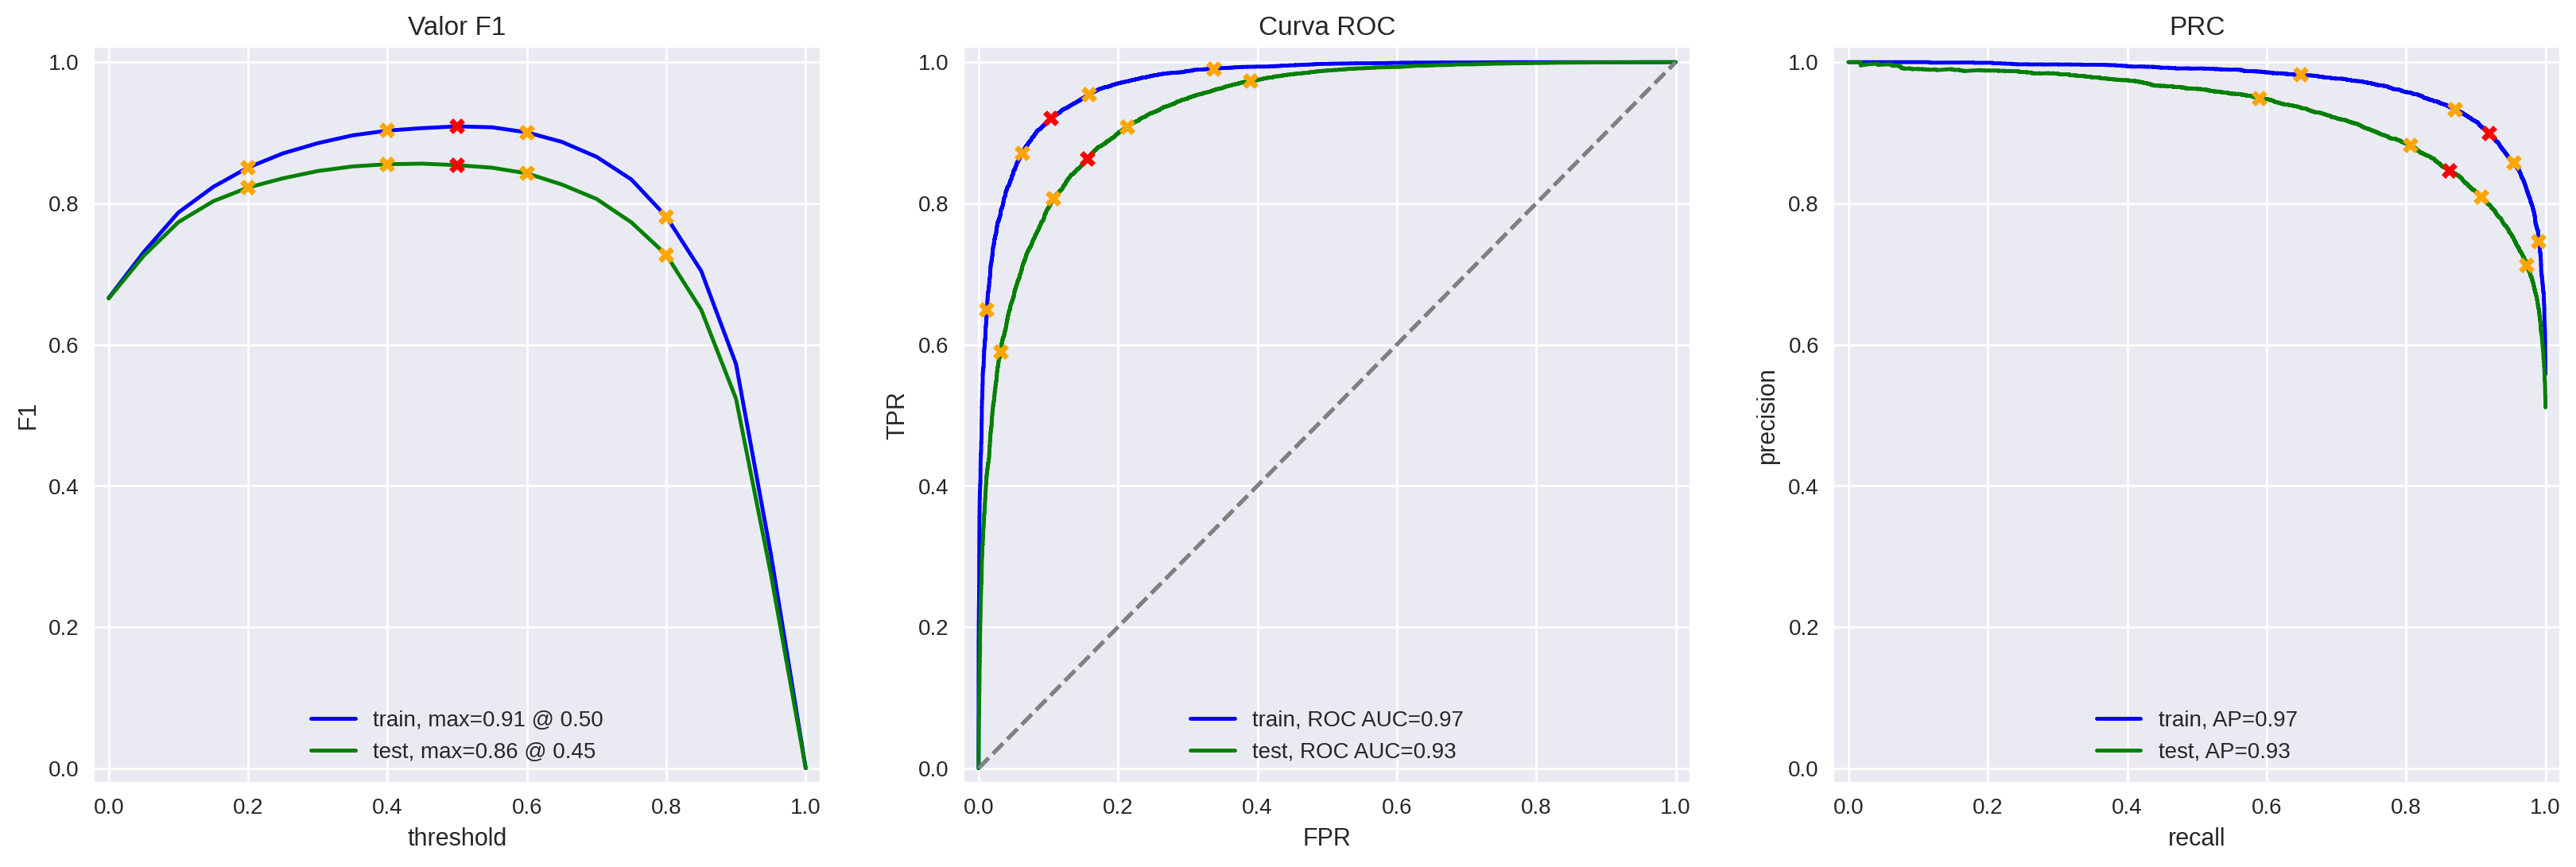

In [46]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

## Minhas Resenhas

In [47]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    'Eu simplesmente não gostei, não é meu tipo de filme.',
    'Bem, eu fiquei entediado e dormi no meio do filme.',
    'Eu fiquei realmente fascinado com o filme',    
    'Os atores pareciam muito velhos e desinteressados, e mesmo assim foram pagos para participar do filme. Que roubo de dinheiro sem vergonha.',
    'Eu não esperava que a nova versão fosse tão boa! Os escritores realmente se importaram com o material original',
    'O filme tem seus prós e contras, mas eu sinto que em geral é um filme decente. Eu posso me imaginar indo assistir novamente.',
    'Que tentativa podre de comédia. Nem uma única piada cai, todo mundo age de forma irritante e barulhenta, nem crianças não vão gostar disso!',
    'Lançar na Netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir episódio após episódio, deste emocionante e inteligente novo drama.'
], columns=['review'])

my_reviews['review_norm'] =  my_reviews['review'].apply(clear_text)

my_reviews

,review,review_norm
0,"Eu simplesmente não gostei, não é meu tipo de ...",eu simplesmente n o gostei n o meu tipo de filme
1,"Bem, eu fiquei entediado e dormi no meio do fi...",bem eu fiquei entediado e dormi no meio do filme
2,Eu fiquei realmente fascinado com o filme,eu fiquei realmente fascinado com o filme
3,Os atores pareciam muito velhos e desinteressa...,os atores pareciam muito velhos e desinteressa...
4,Eu não esperava que a nova versão fosse tão bo...,eu n o esperava que a nova vers o fosse t o bo...
5,"O filme tem seus prós e contras, mas eu sinto ...",o filme tem seus pr s e contras mas eu sinto q...
6,Que tentativa podre de comédia. Nem uma única ...,que tentativa podre de com dia nem uma nica pi...
7,Lançar na Netflix foi uma jogada corajosa e eu...,lan ar na netflix foi uma jogada corajosa e eu...


### Modelo 1

In [63]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.49:  eu simplesmente n o gostei n o meu tipo de filme
0.28:  bem eu fiquei entediado e dormi no meio do filme
0.62:  eu fiquei realmente fascinado com o filme
0.46:  os atores pareciam muito velhos e desinteressados e mesmo assim foram pagos para participar do filme
0.42:  eu n o esperava que a nova vers o fosse t o boa os escritores realmente se importaram com o material
0.48:  o filme tem seus pr s e contras mas eu sinto que em geral um filme decente eu posso me imaginar indo
0.57:  que tentativa podre de com dia nem uma nica piada cai todo mundo age de forma irritante e barulhenta
0.47:  lan ar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir epis dio ap s


### Modelo 2

In [64]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(tfidf_vectorizer_2.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.51:  eu simplesmente n o gostei n o meu tipo de filme
0.48:  bem eu fiquei entediado e dormi no meio do filme
0.58:  eu fiquei realmente fascinado com o filme
0.51:  os atores pareciam muito velhos e desinteressados e mesmo assim foram pagos para participar do filme
0.43:  eu n o esperava que a nova vers o fosse t o boa os escritores realmente se importaram com o material
0.47:  o filme tem seus pr s e contras mas eu sinto que em geral um filme decente eu posso me imaginar indo
0.61:  que tentativa podre de com dia nem uma nica piada cai todo mundo age de forma irritante e barulhenta
0.52:  lan ar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir epis dio ap s


### Modelo 3

In [65]:
texts = my_reviews['review_norm']

tfidf_vectorizer_3 = tfidf_vectorizer_3
my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  eu simplesmente n o gostei n o meu tipo de filme
0.62:  bem eu fiquei entediado e dormi no meio do filme
0.65:  eu fiquei realmente fascinado com o filme
0.62:  os atores pareciam muito velhos e desinteressados e mesmo assim foram pagos para participar do filme
0.51:  eu n o esperava que a nova vers o fosse t o boa os escritores realmente se importaram com o material
0.62:  o filme tem seus pr s e contras mas eu sinto que em geral um filme decente eu posso me imaginar indo
0.67:  que tentativa podre de com dia nem uma nica piada cai todo mundo age de forma irritante e barulhenta
0.62:  lan ar na netflix foi uma jogada corajosa e eu realmente aprecio ser capaz de assistir epis dio ap s


Criamos novos reviews para testar novamente nossos modelos anteriores. Observamos que as probabilidades atribuídas às resenhas criadas foram inferiores às dos conjuntos de teste do modelo. No entanto, os resultados obtidos foram satisfatórios em todos os três modelos avaliados, com o terceiro modelo apresentando o melhor desempenho.

## Conclusão

Treinamos e testamos três modelos diferentes para realizar a análise de sentimentos das reviews de filmes, comparando métricas como o F1-Score. Todos os modelos atenderam ao limiar mínimo definido no projeto, de 0,85. Entre os modelos avaliados, o primeiro, que utiliza NLTK, TF-IDF e Regressão Linear, destacou-se como o melhor. Ele apresentou o maior F1-Score, além de superar os demais nas outras métricas avaliadas, como APS e ROC AUC.